In [1]:
import os, glob
import numpy as np
import pandas as pd

In [2]:
all_file = glob.glob('../../PlusRaid/Data2017/HCP_tmp/AllTestsLabeledLong/*')

In [3]:
info = []
for i in xrange(len(all_file)):
    info.append(all_file[i].split(os.sep)[-1].split('_')[:2] + [all_file[i].split(os.sep)[-1]])

df = pd.DataFrame(info, columns=['userID', 'task', 'file_name'])
df = df.sort_values(['userID'])
df.reset_index(inplace=True)
df.drop(['index'], axis=1, inplace=True)

In [5]:
df = pd.get_dummies(df, columns=['task'])

In [6]:
X_test, y_test = df['file_name'].values, df.iloc[:, 2:].values

In [7]:
root_path = '../../PlusRaid/Data2017/HCP_tmp/AllTestsLabeledLong/'

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset

In [9]:
def to_np(x):
    return x.data.cpu().numpy()

def to_var(x):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x)

In [10]:
import nibabel as nib

/home/neurolab/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [11]:
import nibabel as nib
class BrainDataset(Dataset):
    def __init__(self, root_path, file_list, label_list, train=True):
        self.train = train
        self.input_shape = 27
        self.root_path = root_path
        self.file_list = file_list
        self.label_list = label_list
        
    def __getitem__(self, index):
        img = self.normalize_data(nib.load(os.path.join(self.root_path, self.file_list[index])).get_data())
#         img = self.normalize_data(nib.load(os.path.join(self.root_path, self.file_list[index][:-3])).get_data())
        target = np.argmax(self.label_list[index])
        return img, target
    
    def __len__(self):
        return len(self.label_list)
    
    def normalize_data(self, data):
        if self.train:
            select_idx = np.random.randint(low=self.input_shape, high=data.shape[-1], size=1)[0]
            data = data[8:-8, 8:-8, :-10, select_idx-self.input_shape:select_idx]
        else:
            data = data[8:-8, 8:-8, :-10, :27]
        data = data / data.max(axis=3)[:, :, :, np.newaxis]
        data[~ np.isfinite(data)] = 0
        return data.transpose(3, 0, 1, 2)

In [12]:
class DeepBrain(nn.Module):
    def __init__(self):
        super(DeepBrain, self).__init__()
        self.n_classes = 7
        self.features = nn.Sequential(
            nn.Conv3d(27, 3, kernel_size=1, padding=0),
            nn.BatchNorm3d(3),
            nn.ReLU(inplace = True),
            nn.Conv3d(3, 32, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm3d(32),
            nn.ReLU(inplace = True),
            nn.Conv3d(32, 64, kernel_size=3, stride=2),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace = True),
            nn.Conv3d(64, 64, kernel_size=3, stride=2),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace = True),
            nn.Conv3d(64, 64, kernel_size=(8, 11, 9)),
            ).cuda()
        
        self.classifier = nn.Sequential(
            nn.Linear(64 * 1, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(64, self.n_classes),
            nn.LogSoftmax())
        
        self._initialize_weights()
    def forward(self, x):
        out = self.features(x)
        out = out.view(-1, 64 * 1)
        out = self.classifier(out)
        return out
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.xavier_uniform(m.weight, gain=nn.init.calculate_gain('relu'))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm3d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                n = m.weight.size(1)
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()

In [13]:
num_epochs = 150
batch_size = 16
num_workers = 4
testset = BrainDataset(root_path=root_path, file_list=X_test, label_list=y_test, train=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [14]:
# net = DeepBrain()
# net = torch.load('Model_Multiclass/DeepBrain_epoch_10.pkl')
criterion = nn.NLLLoss().cuda()

In [15]:
net = torch.load('Model_Multiclass/DeepBrain_epoch_finetuning_10_{}.pkl'.format(26)).cuda()

/home/neurolab/anaconda2/lib/python2.7/site-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/neurolab/anaconda2/lib/python2.7/site-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv3d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/neurolab/anaconda2/lib/python2.7/site-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'torch.nn.modules.batchnorm.BatchNorm3d' has changed. you can retrieve the original source code by

In [ ]:
step = 0
net.eval()
predict_prob = []
total_loss, total_accuracy = 0, 0
for i, data in enumerate(testloader, 0):
    inputs, labels = data
    inputs, labels = to_var(inputs), to_var(labels)

    outputs = net(inputs)
    loss = criterion(outputs, labels)

    total_loss += loss.data[0]

    # Compute accuracy
    _, argmax = torch.max(outputs, 1)
    accuracy = (labels == argmax.squeeze()).float().mean()
    total_accuracy += accuracy.data[0]
    predict_prob.append(F.softmax(outputs).data.cpu().numpy())
    

/home/neurolab/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in divide
/home/neurolab/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in divide
/home/neurolab/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in divide
/home/neurolab/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in divide


In [19]:
print 'Epoch_{}:    val_loss:{}      val_accuracy:{}'.format(0, total_loss / (i+1), total_accuracy / (i+1))

Epoch_0:    val_loss:1.08497519879      val_accuracy:0.760334645669


In [29]:
predict_label = np.concatenate(predict_prob, 0)
prob_predict = np.argmax(predict_label, axis=1)

In [43]:
gt = np.argmax(y_test, axis=1)

In [48]:
task_info = []
for i in xrange(len(all_file)):
    task_info.append('_'.join(all_file[i].split(os.sep)[-1].split('_')[1:3]))

In [105]:
np.where(np.array(task_info) == 'SOCIAL_6')

(array([5879, 6243]),)

In [55]:
task_name = list(np.sort(list(set(task_info))))

In [75]:
stat_predict = np.zeros((34, 7))

In [76]:
for i, name in enumerate(X_test):
    stat_predict[task_name.index('_'.join(name.split('_')[1:3])), prob_predict[i]] += 1

In [79]:
final_df = pd.DataFrame(columns=['Label', 'Predict Label', 'Count'])

In [92]:
count = 0
for i in range(34):
    for j in range(7):
        final_df.loc[count] = [task_name[i], df.columns[2:][j], stat_predict[i, j]]
        count += 1

In [94]:
final_df['Count'] = final_df['Count'].astype(int)

In [95]:
final_df = final_df.pivot('Label', 'Predict Label', 'Count')

In [99]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

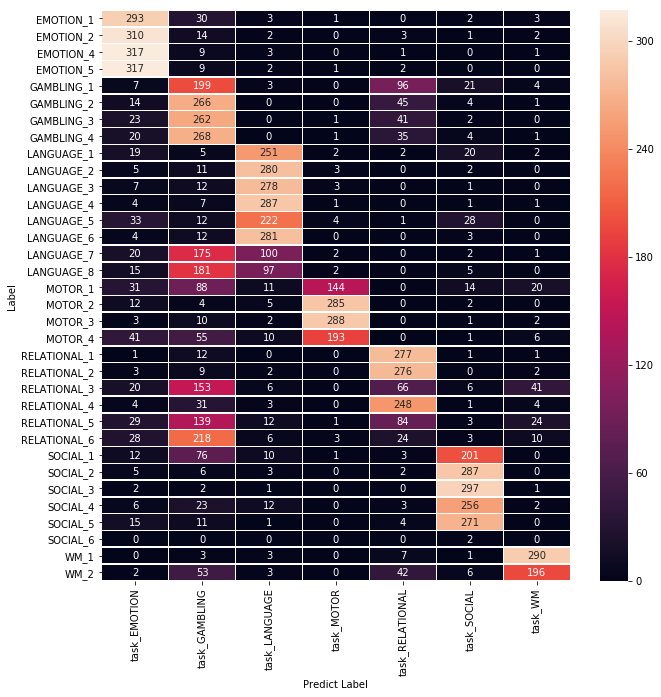

In [100]:
plt.figure(figsize=(10.5, 10.5))
sns.heatmap(final_df, annot=True, fmt="d", linecolor='white', linewidths=0.5)

fig = plt.gcf()